In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklego.meta import ZeroInflatedRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
plt.style.use('fivethirtyeight')

In [4]:
#Read in the data and convert dates to date time objects in UTC 
noaa_utc = pd.read_csv('cleaned_storm_data.csv', parse_dates=[10, 12], date_parser = lambda col: pd.to_datetime(col, utc=True))


In [5]:
#Create a new column representing the length of the storm event
noaa_utc['duration'] = noaa_utc['End_datetime'] - noaa_utc['Start_datetime']

In [6]:
#feature engineering for regions
noaa_utc['State'].replace(to_replace=['WASHINGTON', 'OREGON'], value='PNW', inplace=True)
noaa_utc['State'].replace(to_replace=['NEVADA', 'UTAH', 'ARIZONA', 'NEW MEXICO'], value='Southwest', inplace=True)
noaa_utc['State'].replace(to_replace=['IDAHO', 'MONTANA', 'COLORADO', 'WYOMING'], value='Rockies', inplace=True)
noaa_utc['State'].replace(to_replace=['NORTH DAKOTA', 'SOUTH DAKOTA', 'NEBRASKA', 'KANSAS',
                                      'MINNESOTA', 'IOWA', 'MISSOURI', 'WISCONSIN', 'ILLINOIS',
                                      'INDIANA', 'OHIO', 'MICHIGAN'
                                     ], value='Midwest', inplace=True)
noaa_utc['State'].replace(to_replace=['OKLAHOMA', 'ARKANSAS', 'LOUISIANA', 'MISSISSIPPI', 'TENNESSEE',
                                      'KENTUCKY', 'ALABAMA', 'GEORGIA', 'NORTH CAROLINA', 'SOUTH CAROLINA', 'VIRGINIA',
                                      'WEST VIRGINIA', 'MARYLAND'
                                     ], value='South', inplace=True)
noaa_utc['State'].replace(to_replace=['DELAWARE', 'NEW JERSEY', 'PENNSYLVANIA', 'NEW YORK', 'CONNECTICUT',
                                      'MASSACHUSETTS', 'RHODE ISLAND', 'VERMONT', 'NEW HAMPSHIRE', 'MAINE'
                                     ], value='Northeast', inplace=True)
noaa_utc['State'].replace(to_replace=['GULF OF MEXICO', 'ATLANTIC NORTH', 'ATLANTIC SOUTH', 'HAWAII WATERS', 'GULF OF ALASKA',
                                      'E PACIFIC'
                                     ], value='Ocean', inplace=True)
noaa_utc['State'].replace(to_replace=['LAKE MICHIGAN', 'LAKE ERIE', 'LAKE SUPERIOR', 'LAKE HURON', 'LAKE ST CLAIR',
                                      'LAKE ONTARIO'
                                     ], value='Great Lakes', inplace=True)
noaa_utc['State'].replace(to_replace=['VIRGIN ISLANDS', 'AMERICAN SAMOA', 'GUAM', 'DISTRICT OF COLUMBIA', 'PUERTO RICO',
                                     ], value='US Territories', inplace=True)

In [7]:
#feature engineering for weather
noaa_utc['Weather_type'].replace(to_replace=['Thunderstorm Wind', 'Marine Thunderstorm Wind', 'Lightning', 'Marine Lightning', 
                                             'Tornado', 'Tropical Storm','Marine Tropical Storm','Hurricane (Typhoon)', 'Hurricane', 'Marine Hurricane/Typhoon', 'Hail',
                                             'Winter Storm', 'Winter Weather', 'Blizzard', 'Extreme Cold/Wind Chill', 'Marine Hail',
                                             'Flood','Coastal Flood', 'Lakeshore Flood', 'Flash Flood' ,'Strong Wind', 'Marine Strong Wind'
                                            ], value='Severe Weather', inplace=True)

In [8]:
#Convert categorical weather/region type columns into numerical data via One Hot Encoding 
oe_style = OneHotEncoder()
oe_results_weather = oe_style.fit_transform(noaa_utc[["Weather_type"]])
noaa_utc = noaa_utc.join(pd.DataFrame(oe_results_weather.toarray(), columns=oe_style.categories_))

oe_results_state = oe_style.fit_transform(noaa_utc[["State"]])
noaa_utc = noaa_utc.join(pd.DataFrame(oe_results_state.toarray(), columns=oe_style.categories_))



In [15]:
#Check to make sure everything worked and what it looks like 
noaa_utc.head()

,Unnamed: 0,Event_id,State,State_id,Year,Month,Weather_type,County_type,County_id,County,...,"(Midwest,)","(Northeast,)","(Ocean,)","(PNW,)","(Rockies,)","(ST LAWRENCE R,)","(South,)","(Southwest,)","(TEXAS,)","(US Territories,)"
0,0,5570068,Midwest,17,1996,October,High Wind,Z,34,HANCOCK,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5570362,South,40,1996,October,Severe Weather,C,13,BRYAN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,5570363,South,40,1996,October,Severe Weather,C,137,STEPHENS,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,5537534,CALIFORNIA,6,1996,January,Severe Weather,Z,9,COASTAL MONTEREY COUNTY,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5538413,Midwest,27,1996,January,Severe Weather,Z,64,YELLOW MEDICINE,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [9]:
split_date = 2015
noaa_train = noaa_utc.loc[noaa_utc.Year <= split_date].copy()
noaa_test = noaa_utc.loc[noaa_utc.Year > split_date].copy()

# Create Features

In [10]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.Start_datetime
    df['hour'] = df['date'].dt.hour
    df['length'] = df['duration'].dt.total_seconds()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['Deaths_direct', 'Deaths_indirect', 'Injuries_direct', 'Injuries_indirect', 'Crop_damage', 'length',
    ('Astronomical Low Tide',),
                        ('Avalanche',),            ('Cold/Wind Chill',),
                      ('Debris Flow',),                  ('Dense Fog',),
                      ('Dense Smoke',),                    ('Drought',),
                       ('Dust Devil',),                 ('Dust Storm',),
                   ('Excessive Heat',),               ('Freezing Fog',),
                     ('Frost/Freeze',),               ('Funnel Cloud',),
                             ('Heat',),                 ('Heavy Rain',),
                       ('Heavy Snow',),                  ('High Surf',),
                        ('High Wind',),                  ('Ice Storm',),
                 ('Lake-Effect Snow',),           ('Marine Dense Fog',),
                 ('Marine High Wind',), ('Marine Tropical Depression',),
                  ('Northern Lights',),                ('Rip Current',),
                           ('Seiche',),             ('Severe Weather',),
                            ('Sleet',),                ('Sneakerwave',),
                 ('Storm Surge/Tide',),        ('Tropical Depression',),
                          ('Tsunami',),               ('Volcanic Ash',),
                 ('Volcanic Ashfall',),                 ('Waterspout',),
                         ('Wildfire',),                     ('ALASKA',),
                       ('CALIFORNIA',),                    ('FLORIDA',),
                      ('Great Lakes',),                     ('HAWAII',),
                          ('Midwest',),                  ('Northeast',),
                            ('Ocean',),                        ('PNW',),
                          ('Rockies',),              ('ST LAWRENCE R',),
                            ('South',),                  ('Southwest',),
                            ('TEXAS',),             ('US Territories',)
            ]]

           
    if label:
        y = df[label]
        return X, y
    return X

In [16]:
#divy things up into train and test splits
X_train, y_train = create_features(noaa_train, label='Property_damage')
X_test, y_test = create_features(noaa_test, label='Property_damage')


C:\Users\apanc\AppData\Local\Temp\ipykernel_19272\2951027403.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
c:\Users\apanc\anaconda3\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
C:\Users\apanc\AppData\Local\Temp\ipykernel_19272\2951027403.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
c:\Users\apanc\anaconda3\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested seque

# Create Models

In [81]:
# OPTIONAL

# zir = ZeroInflatedRegressor(
#     classifier=RandomForestClassifier(),
#     regressor=RandomForestRegressor()
# )

# zir.fit(X_train, y_train)

ZeroInflatedRegressor(classifier=RandomForestClassifier(),
                      regressor=RandomForestRegressor())

In [17]:
reg = xgb.XGBRegressor(base_score=0)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
       ) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [18]:
# plt.scatter(x=noaa_test['Property_damage'], y=noaa_test['PD_Prediction'])
reg.score(X_test, y_test)

-0.06068897770100601

In [84]:
#OPTIONAL

# zir.score(X_test, y_test)

0.04480004839228435

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.


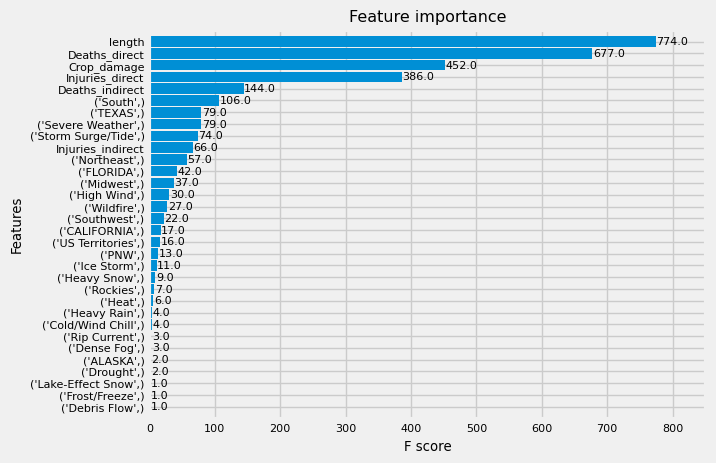

In [31]:
plt.rcParams.update({'font.size': 8})
_ = plot_importance(reg, height=0.9)

The feature engineering wasn't incredibly useful but it seems that the model placed the most emphasis on the duration of the storm and how many lives in claimed or injuries it caused, which makes sense intuitively that those things would be correlated with property damage

# Forecast on Test Set

In [20]:
#Create a column in the test set to represent the predicted property damage 
# noaa_test['zir_PD_Prediction'] = zir.predict(X_test) #OPTIONAL LINE
noaa_test['xgb_PD_Prediction'] = reg.predict(X_test)

# Error Metrics On Test Set
Our RMSE error is 1861622239481302.2
Our MAE error is 682913.0854803688  
Our MAPE error is 8.708975804329357e+20
(similar values for both models)

In [21]:
mean_squared_error(y_true=noaa_test['Property_damage'],
                   y_pred=noaa_test['xgb_PD_Prediction'])

1861622239481302.2

In [22]:
mean_absolute_error(y_true=noaa_test['Property_damage'],
                   y_pred=noaa_test['xgb_PD_Prediction'])

682913.0854803688

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.


In [23]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_true=noaa_test['Property_damage'],
                   y_pred=noaa_test['xgb_PD_Prediction'])

8.708975804329357e+20

# Look at Worst and Best Predicted Days

In [25]:
noaa_test['error'] = noaa_test['Property_damage'] - noaa_test['xgb_PD_Prediction']
noaa_test['abs_error'] = noaa_test['error'].apply(np.abs)
error_by_day = noaa_test.groupby(['year','month','dayofmonth']) \
    .mean()[['Property_damage','xgb_PD_Prediction','error','abs_error']]

In [29]:
import plotly.express as px

px.scatter(x=error_by_day['Property_damage'], y=error_by_day['xgb_PD_Prediction'])

In [63]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

,,,Property_damage,PD_Prediction,error,abs_error
year,month,dayofmonth,,,,
2018,10,9,1.101134e+05,5.948685e+07,-5.937673e+07,5.958797e+07
2016,10,9,1.271267e+07,7.111815e+07,-5.840548e+07,6.911773e+07
2018,10,10,1.948448e+07,4.976154e+07,-3.027706e+07,4.473279e+07
2022,9,27,4.036842e+04,1.742549e+07,-1.738512e+07,1.745183e+07
2019,3,22,4.839207e+03,1.420210e+07,-1.419727e+07,1.420325e+07
2022,9,29,2.636754e+05,1.316816e+07,-1.290449e+07,1.290552e+07
2018,9,17,1.293468e+06,1.363230e+07,-1.233884e+07,1.269910e+07
2020,9,15,4.723574e+06,1.567692e+07,-1.095335e+07,1.753254e+07
2017,9,11,2.199561e+05,8.835482e+06,-8.615525e+06,9.027993e+06


Seems like late summer/early fall had a lot of overforecasted days

In [64]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

Property_damage  PD_Prediction         error  \
year month dayofmonth                                                 
2018 11    8              3.953489e+08   5.467722e+07  3.406716e+08   
2017 8     26             2.238928e+08   2.309603e+07  2.007967e+08   
           27             1.325063e+08   2.098285e+06  1.304080e+08   
     9     20             1.277204e+08   2.893058e+06  1.248273e+08   
2020 8     26             1.251421e+08   1.549150e+06  1.235930e+08   
2018 10    24             8.339583e+07   5.098955e+06  7.829688e+07   
2016 10    9              1.271267e+07   7.111815e+07 -5.840548e+07   
2017 8     25             6.667526e+07   1.546472e+07  5.121054e+07   
2018 10    9              1.101134e+05   5.948685e+07 -5.937673e+07   
2021 8     29             4.701001e+07   8.270181e+04  4.692731e+07   

                          abs_error  
year month dayofmonth                
2018 11    8           3.408245e+08  
2017 8     26          2.010964e+08  
           27          1.305897e+08  
     9     20          1.248568e+08  
2020 8     26          1.235976e+08  
2018 10    24          7.875346e+07  
2016 10    9           6.911773e+07  
2017 8     25          6.734377e+07  
2018 10    9           5.958797e+07  
2021 8     29          4.699056e+07

Our Zero Inflated Regressor seemed to handle predicting zero values well

In [65]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

Property_damage  PD_Prediction  error  abs_error
year month dayofmonth                                                  
2020 11    20                      0.0            0.0    0.0        0.0
2022 1     12                      0.0            0.0    0.0        0.0
2020 1     21                      0.0            0.0    0.0        0.0
2018 3     9                       0.0            0.0    0.0        0.0
2020 1     27                      0.0            0.0    0.0        0.0
2021 12    7                       0.0            0.0    0.0        0.0
2018 2     27                      0.0            0.0    0.0        0.0
2020 1     20                      0.0            0.0    0.0        0.0
           30                      0.0            0.0    0.0        0.0
2018 2     13                      0.0            0.0    0.0        0.0

In [32]:
#Export model using joblib
import joblib

filename = 'finalized_xgb_model.sav'
joblib.dump(reg, filename)


['finalized_xgb_model.sav']